# Music Store Data Analysis with SQL + Python


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import warnings
warnings.filterwarnings("ignore")



user = "postgres"
password = "admin123"
host = "localhost"
port = "5432"
database = "Music_DB"

connection_string = f"postgresql+psycopg2://{user}:{password}@{host}:{port}/{database}"
engine = create_engine(connection_string)


## 1. Senior-most employee by job title

In [16]:
query = """
SELECT first_name, last_name, title
FROM employee
ORDER BY levels DESC 
LIMIT 1;
"""

df = pd.read_sql(query, engine)


name = f"{df.loc[0, 'first_name']} {df.loc[0, 'last_name']}"
title = df.loc[0, 'title']

print(f" Senior-most employee: {name}, Title: {title}")


 Senior-most employee: Mohan                                              Madan                                             , Title: Senior General Manager


## 2. Countries with Most Invoices

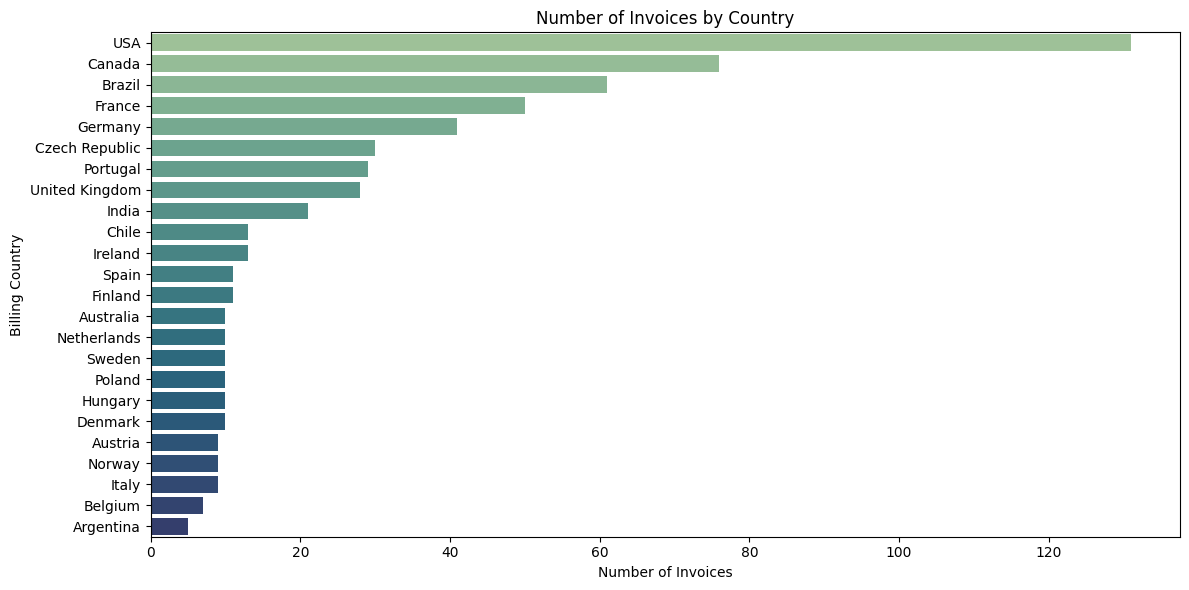

In [4]:
query = """
SELECT COUNT(customer_id) AS no_invoice, billing_country 
FROM invoice
GROUP BY billing_country
ORDER BY no_invoice DESC;
"""
df = pd.read_sql(query, engine)
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x="no_invoice", y="billing_country", palette="crest")
plt.title("Number of Invoices by Country")
plt.xlabel("Number of Invoices")
plt.ylabel("Billing Country")
plt.tight_layout()
plt.show()

## 4. City with Highest Revenue

In [6]:
query = """
SELECT billing_city, ROUND(SUM(total)::numeric, 2) AS total_invoice
FROM invoice
GROUP BY billing_city
ORDER BY total_invoice DESC
LIMIT 1;
"""
df = pd.read_sql(query, engine)
print(f"Top City: {df['billing_city'][0]}, Total Revenue: ${df['total_invoice'][0]}")

Top City: Prague, Total Revenue: $273.24


## 5. Best Customer by Spending

Best Customer: R                                                  Madhav                                            , Spent: $144.54


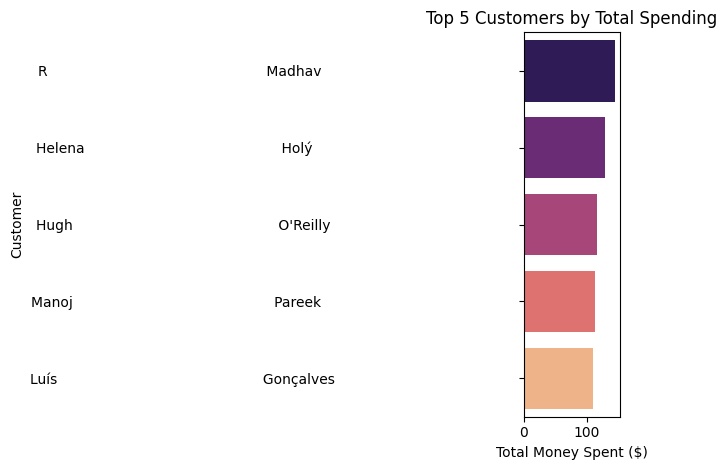

In [7]:
query = """
SELECT 
    c.customer_id, c.first_name, c.last_name, 
    SUM(invoice.total) AS money_spent
FROM customer c
JOIN invoice ON c.customer_id = invoice.customer_id
GROUP BY c.customer_id
ORDER BY money_spent DESC
LIMIT 5;
"""
df = pd.read_sql(query, engine)
df['customer_name'] = df['first_name'] + ' ' + df['last_name']
print(f"Best Customer: {df['customer_name'][0]}, Spent: ${df['money_spent'][0]:.2f}")
sns.barplot(data=df, x="money_spent", y="customer_name", palette="magma")
plt.title("Top 5 Customers by Total Spending")
plt.xlabel("Total Money Spent ($)")
plt.ylabel("Customer")
plt.tight_layout()
plt.show()

## 6. Rock Music Listeners

In [8]:
query = """
SELECT DISTINCT 
    c.email, c.first_name, c.last_name, g.name AS genre
FROM customer c
JOIN invoice i ON c.customer_id = i.customer_id
JOIN invoice_line il ON i.invoice_id = il.invoice_id
JOIN track t ON il.track_id = t.track_id
JOIN genre g ON t.genre_id = g.genre_id
WHERE g.name = 'Rock'
ORDER BY c.email;
"""
df = pd.read_sql(query, engine)
df.head(10)

,email,first_name,last_name,genre
0,aaronmitchell@yahoo.ca,Aaron ...,Mitchell ...,Rock
1,alero@uol.com.br,Alexandre ...,Rocha ...,Rock
2,astrid.gruber@apple.at,Astrid ...,Gruber ...,Rock
3,bjorn.hansen@yahoo.no,Bjørn ...,Hansen ...,Rock
4,camille.bernard@yahoo.fr,Camille ...,Bernard ...,Rock
5,daan_peeters@apple.be,Daan ...,Peeters ...,Rock
6,diego.gutierrez@yahoo.ar,Diego ...,Gutiérrez ...,Rock
7,dmiller@comcast.com,Dan ...,Miller ...,Rock
8,dominiquelefebvre@gmail.com,Dominique ...,Lefebvre ...,Rock
9,edfrancis@yachoo.ca,Edward ...,Francis ...,Rock


## 7. Top 10 Rock Artists by Songs

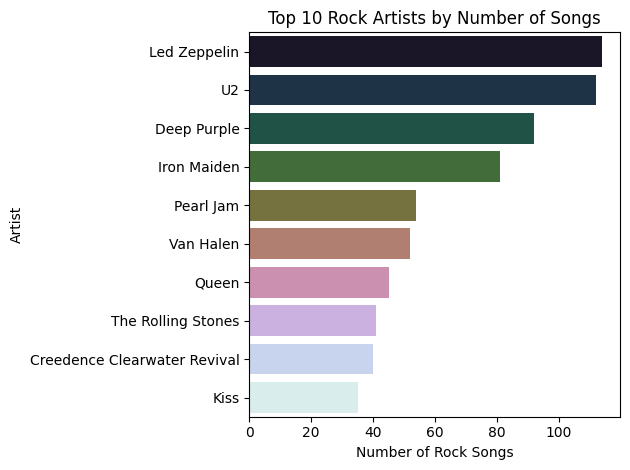

In [9]:
query = """
SELECT 
    ar.name AS artist_name,
    COUNT(t.track_id) AS no_of_rock_songs
FROM track t
JOIN genre g ON t.genre_id = g.genre_id
JOIN album al ON t.album_id = al.album_id
JOIN artist ar ON al.artist_id = ar.artist_id
WHERE g.name = 'Rock'
GROUP BY ar.artist_id, ar.name
ORDER BY no_of_rock_songs DESC
LIMIT 10;
"""
df = pd.read_sql(query, engine)
sns.barplot(data=df, x="no_of_rock_songs", y="artist_name", palette="cubehelix")
plt.title("Top 10 Rock Artists by Number of Songs")
plt.xlabel("Number of Rock Songs")
plt.ylabel("Artist")
plt.tight_layout()
plt.show()

## 8. Songs Longer Than Average

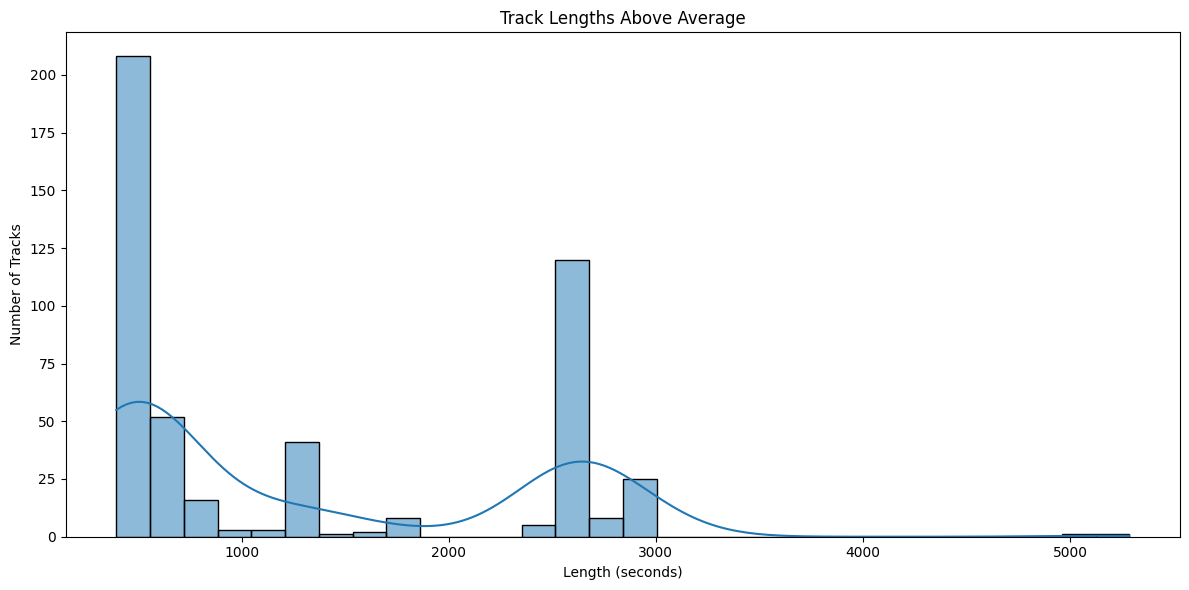

In [10]:
query = """
SELECT name, milliseconds 
FROM track
WHERE milliseconds > (SELECT AVG(milliseconds) FROM track)
ORDER BY milliseconds DESC;
"""
df = pd.read_sql(query, engine)
plt.figure(figsize=(12, 6))
sns.histplot(df['milliseconds'] / 1000, bins=30, kde=True)
plt.title("Track Lengths Above Average")
plt.xlabel("Length (seconds)")
plt.ylabel("Number of Tracks")
plt.tight_layout()
plt.show()

## 9. Total Revenue

In [11]:
query = "SELECT ROUND(SUM(total)::numeric, 2) AS total_revenue FROM invoice;"
df = pd.read_sql(query, engine)
print(f"Total Revenue: ${df['total_revenue'][0]}")

Total Revenue: $4709.43


## 10. Top 5 Most Sold Tracks

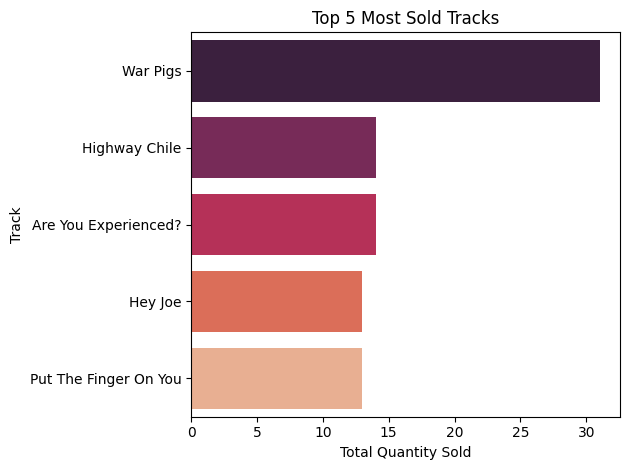

In [12]:
query = """
SELECT 
    t.name AS track_name,
    SUM(il.quantity) AS total_quantity_sold
FROM invoice_line il
JOIN track t ON il.track_id = t.track_id
GROUP BY t.track_id, track_name
ORDER BY total_quantity_sold DESC
LIMIT 5;
"""
df = pd.read_sql(query, engine)
sns.barplot(data=df, x="total_quantity_sold", y="track_name", palette="rocket")
plt.title("Top 5 Most Sold Tracks")
plt.xlabel("Total Quantity Sold")
plt.ylabel("Track")
plt.tight_layout()
plt.show()

## 11. Genre with Most Tracks

In [13]:
query = """
SELECT 
    g.name AS genre,
    COUNT(t.track_id) AS number_of_tracks
FROM genre g
JOIN track t ON g.genre_id = t.genre_id
GROUP BY g.genre_id, genre
ORDER BY number_of_tracks DESC
LIMIT 1;
"""
df = pd.read_sql(query, engine)
print(f"Genre with most tracks: {df['genre'][0]} ({df['number_of_tracks'][0]} tracks)")

Genre with most tracks: Rock (1297 tracks)


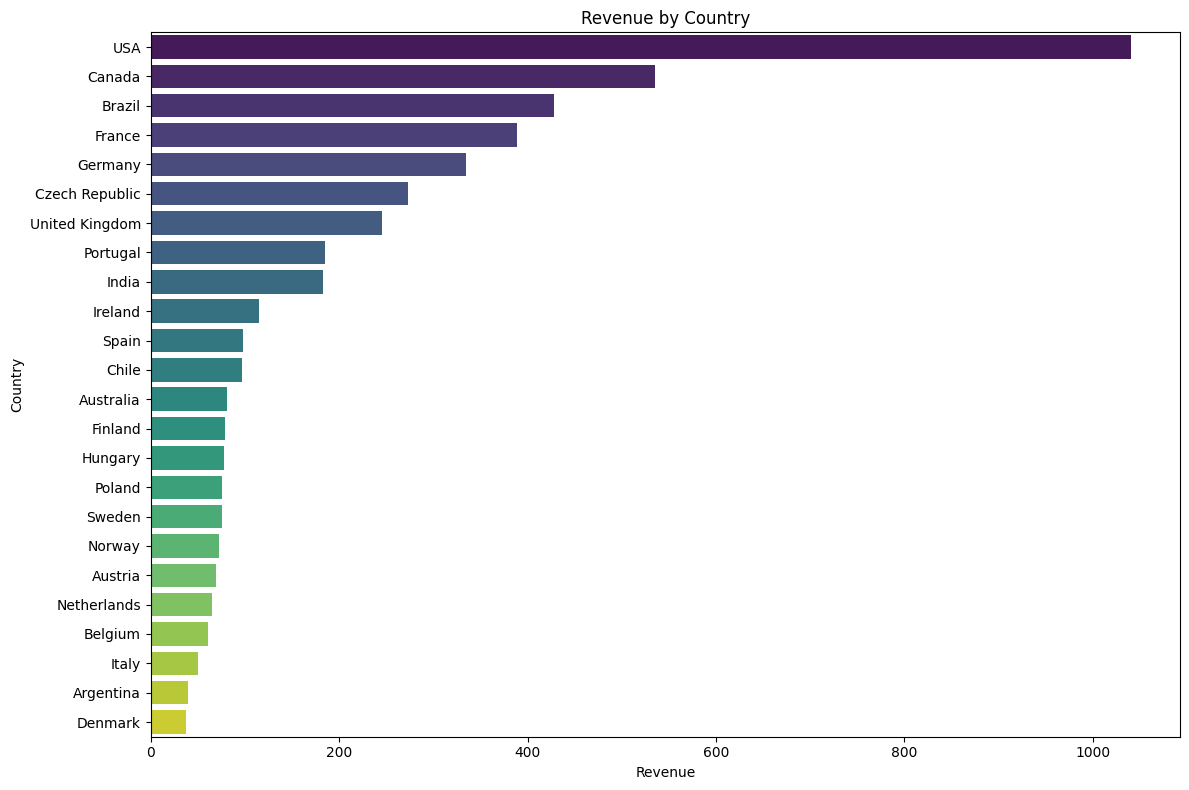

In [15]:
query = """
SELECT 
    billing_country,
    ROUND(SUM(total)::numeric, 2) AS revenue
FROM invoice
GROUP BY billing_country
ORDER BY revenue DESC;
"""
df = pd.read_sql(query, engine)

plt.figure(figsize=(12, 8))
sns.barplot(data=df, x="revenue", y="billing_country", palette="viridis")
plt.title("Revenue by Country")
plt.xlabel("Revenue")
plt.ylabel("Country")
plt.tight_layout()
plt.show()

#                                                                   Thank You